Predictive Filter Flow for Non-Uniform Motion Blur Removal
================
**Author**: `Shu Kong <https://www.ics.uci.edu/~skong2/pff.html>`

**Date**: Nov. 2018

This is a jupyter demo for showing how to train, evaluate, and visualize the model of non-uniform motion deblur. It squeezes the following parts. Please read through, uncomment lines and run accordingly for your interest.

-  defining model architecture
-  defining the loss function
-  training protocal
-  evaluation protocal
-  analysis using PCA, k-means and t-SNE.


Others to notice: 
- Pytorch is used for this work.
- Please manually install packages as shown below if necessary
- For the training set, the DIV2K dataset is not uploaded due to its large size. If you want to train the model using the whole training set, please download manually, chop each image into overlapping 512x512 sub-images, and put them in the corresponding folder (read through this jupyter script to see where to put them:-) For demonstration and turtorial purpose, other small-scale training images are uploaded here.

import packages
------------------

Some packages are installed automatically if you use Anaconda. As pytorch is used here, you are expected to install that in your machine. 

In [10]:
from __future__ import print_function, division
import os, random, time, copy
from skimage import io, transform
import numpy as np
import os.path as path
import scipy.io as sio
from scipy import misc
from scipy import ndimage, signal
import scipy
import pickle

import math
import matplotlib.pyplot as plt
from PIL import Image
from io import BytesIO
from skimage import data, img_as_float
from skimage.measure import compare_ssim as ssim
from skimage.measure import compare_psnr as psnr

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler 
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets, models, transforms

from libs_deblur.utils.metrics import *
from libs_deblur.utils.flow_functions import *
from libs_deblur.models.pixel_embedding_model import *
from libs_deblur.datasetMotionBlur import *
from libs_deblur.trainvalGaussBlur import *
import libs_deblur.pyblur
import warnings # ignore warnings
warnings.filterwarnings("ignore")


 Setup config parameters
 -----------------
 
 There are several things to setup, like which GPU to use, where to read images and save files, etc. Please read and understand this. By default, you should be able to run this script smoothly by changing nothing.

In [11]:
# set device, which gpu to use.
device ='cpu'
if torch.cuda.is_available(): device='cuda:0'

################## set attributes for this project/experiment ##################
# config result folder
exp_dir = './libs_deblur' # experiment directory, used for reading the init model
project_name = 'demo' # name this project as "demo", used for saving files
path_to_root = './libs_deblur/dataset' # where to fetch data


batch_size = 16 # small batch size for demonstration; using larger batch size (like 56 and 64) for training

embedding_dim = 16 # dimension of the learned embedding space
kernel_size = 17 # the kernel size in the filter flow
cropSize = [64, 64] # patch size for training the model
sigmaMin=0.5
sigmaMax=2

lambda_norm = 0.1
total_epoch_num = 5 # total number of epoch in training
base_lr = 0.0005 # base learning rate

torch.cuda.device_count()
torch.cuda.empty_cache()

save_dir = os.path.join(exp_dir, project_name) # where to save the log file and trained models.
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)
log_filename = os.path.join(save_dir, 'train.log')

./libs_deblur\demo


Define model architecture
---------

Here is the definition of the model architecture. 

In [12]:
device ='cpu'
if torch.cuda.is_available(): device='cuda:0'
##
##initModel = PixelEmbedModelResNet18().to(device)

class SiamesePixelEmbed(nn.Module):
    def __init__(self, emb_dimension=64, filterSize=11, device='cpu', pretrained=False):
        super(SiamesePixelEmbed, self).__init__()
        self.device = device
        self.emb_dimension = emb_dimension  
        self.PEMbase = PixelEmbedModelResNet18(emb_dimension=self.emb_dimension, pretrained=pretrained)  
        self.rawEmbFeature1 = 0
        self.rawEmbFeature2 = 0        
        self.embFeature1_to_2 = 0
        self.embFeature1_to_2 = 0
        self.filterSize = filterSize
        self.filterSize2Channel = self.filterSize**2
                
        self.ordered_embedding = nn.Sequential(            
            nn.Conv2d(self.emb_dimension, self.filterSize2Channel, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(self.filterSize2Channel),     
            nn.Conv2d(self.filterSize2Channel, self.filterSize2Channel, kernel_size=3, padding=1, bias=False),
            nn.ReLU(True),
            nn.BatchNorm2d(self.filterSize2Channel),            
            nn.Conv2d(self.filterSize2Channel, self.filterSize2Channel, kernel_size=3, padding=1, bias=True)
        )
        
        
    def forward(self, inputs1, inputs2):        
        
        self.rawEmbFeature1 = self.PEMbase.forward(inputs1)
        
        self.embFeature1_to_2 = self.ordered_embedding(self.rawEmbFeature1)        
        self.embFeature1_to_2 = F.softmax(self.embFeature1_to_2, 1)

##        print("Self embed",self.embFeature1_to_2.size())        
        return self.embFeature1_to_2


In [13]:

initModel = SiamesePixelEmbed()


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Define loss function
---------

Here is the L1 loss at pixel level, including how to warp the image with the predictive filter flow.

In [15]:
class LossOrderedPairReconstruction(nn.Module):
    def __init__(self, device='cpu', filterSize=11):
        super(LossOrderedPairReconstruction, self).__init__()
        self.device = device
        self.filterSize = filterSize        
        self.filterSize2Channel = self.filterSize**2
        self.reconstructImage = 0
        
    def forward(self, image1, image2, filters_img1_to_img2):
        N,C,H,W = image1.size()
        self.reconstructImage = self.rgbImageFilterFlow(image1, filters_img1_to_img2)
        diff = self.reconstructImage - image2               
        diff = torch.abs(diff)       
        totloss = torch.sum(torch.sum(torch.sum(torch.sum(diff))))        
        return totloss/(N*C*H*W)
    
    
    def rgbImageFilterFlow(self, img, filters):                
        inputChannelSize = 1
        outputChannelSize = 1
        N = img.size(0)
        paddingFunc = nn.ZeroPad2d(int(self.filterSize/2))
        img = paddingFunc(img)        
        imgSize = [img.size(2),img.size(3)]
        
        out_R = F.unfold(img[:,0,:,:].unsqueeze(1), (self.filterSize, self.filterSize))
        out_R = out_R.view(N, out_R.size(1), imgSize[0]-self.filterSize+1, imgSize[1]-self.filterSize+1)    
        #out_R = paddingFunc(out_R)
        out_R = torch.mul(out_R, filters)
        out_R = torch.sum(out_R, dim=1).unsqueeze(1)

        out_G = F.unfold(img[:,1,:,:].unsqueeze(1), (self.filterSize, self.filterSize))
        out_G = out_G.view(N, out_G.size(1), imgSize[0]-self.filterSize+1, imgSize[1]-self.filterSize+1)    
        #out_G = paddingFunc(out_G)
        out_G = torch.mul(out_G, filters)
        out_G = torch.sum(out_G, dim=1).unsqueeze(1)

        out_B = F.unfold(img[:,2,:,:].unsqueeze(1), (self.filterSize, self.filterSize))
        out_B = out_B.view(N, out_B.size(1), imgSize[0]-self.filterSize+1, imgSize[1]-self.filterSize+1)    
        #out_B = paddingFunc(out_B)
        out_B = torch.mul(out_B, filters)
        out_B = torch.sum(out_B, dim=1).unsqueeze(1)
        return torch.cat([out_R, out_G, out_B], 1)

Setup dataset
-----------

Here is where to fetch training and testing dataset.

In [16]:
################## dataset ###################
transform4Image = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((127.,127.,127.),(127.,127.,127.)) # (mean, std)
    ]) # (mean, std)

whole_datasets = {set_name: 
                  Dataset4MotionBlur(root_dir=path_to_root,
                                     size=cropSize, set_name=set_name, 
                                     transform=transform4Image, 
                                     sigmaMin=sigmaMin, sigmaMax=sigmaMax)
                  for set_name in ['train', 'val']}


dataloaders = {set_name: DataLoader(whole_datasets[set_name], 
                                    batch_size=batch_size,
                                    shuffle=set_name=='train', 
                                    num_workers=5) # num_work can be set to batch_size
               for set_name in ['train', 'val']}

dataset_sizes = {set_name: len(whole_datasets[set_name]) for set_name in ['train', 'val']}
print(dataset_sizes)

{'train': 400, 'val': 6}


In [17]:
whole_datasets['train'].__getitem__(0)

(tensor([[[ 0.0000e+00,  0.0000e+00, -4.0284e-13,  1.1860e-11, -3.5421e-11,
            6.1313e-11, -4.0412e-11, -2.9587e-11, -5.4199e-10,  5.0678e-09,
           -2.3122e-08,  6.6677e-08, -9.8413e-08,  1.1531e-09,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00,  1.7878e-11, -2.3186e-10,  8.7487e-10,
           -2.3410e-09,  4.2918e-09, -2.0886e-09, -1.9990e-08,  1.0202e-07,
           -3.2219e-07,  7.4034e-07, -1.0700e-06, -1.0126e-07, -2.8045e-05,
            1.1350e-06, -1.6368e-07,  1.1450e-08,  6.3670e-11,  0.0000e+00,
            0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
          [ 0.0000e+00,  0.0000e+00, -1.7084e-10,  1.5850e-09, -5.9807e-09,
            1.6318e-08, -3.0054e-08,  9.3814e-09,  1.8517e-07, -9.5580e-07,
            3.2036e-06, -7.9382e-06,  1.2258e-05,  5.2133e-06,  1.1218e-04,
          

In [18]:

exp_dir = './libs_deblur' # experiment directory, used for reading the init model
project_name = 'demo' # name this project as "demo", used for saving files
path_to_root = './libs_deblur/dataset' # where to fetch data


batch_size = 64 # small batch size for demonstration; using larger batch size (like 56 and 64) for training

embedding_dim = 16 # dimension of the learned embedding space
kernel_size = 11 # the kernel size in the filter flow
cropSize = [64, 64] # patch size for training the model
sigmaMin=0.5
sigmaMax=2

lambda_norm = 0.1
total_epoch_num = 5 # total number of epoch in training
base_lr = 0.0005 # base learning rate

torch.cuda.device_count()
torch.cuda.empty_cache()

save_dir = os.path.join(exp_dir, project_name) # where to save the log file and trained models.
print(save_dir)    
if not os.path.exists(save_dir): os.makedirs(save_dir)
log_filename = os.path.join(save_dir, 'train.log')

./libs_deblur\demo


Training demo
-------------

Run this cell to train the model (essentially resuming the training over the model provided here). Stop it if you do not want to keep training. This is just for demonstrating how to train and how to tweak the architecture.


In [21]:
################## init model ###################

#init_Model = PixelEmbedModelResNet18().to(device)



#initModel.to(device);


# decreasing the momentum in batch normalization, as the default is too large for this work.
allLayer_dict = initModel.state_dict()
child_counter = 0
for child in initModel.PEMbase.children():
    for i in range(len(child)):        
        if 'BatchNorm2d' in str(type(child[i])): 
            child[i].momentum=0.001
            #print(child[i])            

for i in range(len(initModel.ordered_embedding)):    
    if 'BatchNorm2d' in str(type(initModel.ordered_embedding[i])): 
            initModel.ordered_embedding[i].momentum=0.001
            #print(initModel.ordered_embedding[i])
            
child_counter = 0
for child in initModel.children():
    #print(" child", child_counter, "is:")
    #print(child)
    child_counter += 1            

In [22]:
loss_1_to_2 = LossOrderedPairReconstruction(device=device, filterSize=kernel_size)

loss_l1norm = nn.L1Loss(size_average=True)

optimizer_ft = optim.Adam([{'params': initModel.PEMbase.parameters()},
                           {'params': initModel.ordered_embedding.parameters(), 'lr': base_lr},                           
                         ], lr=base_lr)


In [23]:
device = 'cpu'

################## start training ###################
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=int(total_epoch_num/5), gamma=0.5)

fn = open(log_filename,'w')
fn.write(log_filename+'\t'+device+'\n\n')
#fn.write(path.basename(__file__)+'\n\n')
fn.close()
file_to_note_bestModel = os.path.join(save_dir,'note_bestModel.log')
fn = open(file_to_note_bestModel, 'w')
fn.write('Record of best models on the way.\n')
fn.close()

model_ft = train_model(initModel, dataloaders, dataset_sizes, 
                       loss_1_to_2, 
                       optimizer_ft, exp_lr_scheduler,
                       num_epochs= 15 , 
                       work_dir=save_dir, device=device)



Epoch 1/15
----------
train
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64

Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
	loss: 0.088670
val
Image 1 siz

Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Si

Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
	loss: 0.084379
val
Image 1 size: torch.Size([6, 3, 64, 64])
Image 2 size: torch.Size([6, 3, 64, 64])
Out torch.Size([6, 64, 64, 64])
	loss: 0.196983

Epoch 9/15
----------
train
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Ou

Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Si

Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64, 64, 64])
Image 1 size: torch.Size([16, 3, 64, 64])
Image 2 size: torch.Size([16, 3, 64, 64])
Out torch.Size([16, 64

Evaluation/testing demo
-----------
Load a pretrained model and evaluate over the test set.

In [ ]:
loss_ImageReconst = LossOrderedPairReconstruction(device=device, filterSize=kernel_size)


################## load model ###################
path_to_save_paramOnly = os.path.join(exp_dir,'bestValModel.paramOnly')


print(path_to_save_paramOnly)


In [ ]:
curmodel = model_ft

In [ ]:
curmodel.to(device);    
#print(curmodel.state_dict)
curmodel.eval() # set it to evaluation mode
#curmodel.train()
#curmodel.training = False
print(curmodel.training)

In [ ]:
################## evaluate over validation set ###################
transform4Image = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((127.,127.,127.),(127.,127.,127.)) # (mean, std)
    ]) # (mean, std)


# moderateBlurDataset  severeBlurDataset
subset = 'New folder' 
valset = Dataset4MotionBlur(root_dir=path_to_root, size=[64,64], # 64x64
                            set_name=subset, transform=transform4Image,
                            sigmaMin=sigmaMin, sigmaMax=sigmaMax,
                            downsampleFactor=4)

valdataloader = DataLoader(valset, batch_size=1,shuffle=False, num_workers=1) # num_work can be set to batch_size
print(len(valset))

objDemoShowFlow = DemoShowFlow()

In [ ]:
objDemoShowFlow

Full resolution testing
================

We run this model over overlapping patches, and mosaic them for the final full-resolution result. As there are two subsets in the testing set, please change the subset name to evaluate separately for moderate blur and large blur situations, respectively.

In [ ]:
# severeBlurDataset_fullRes moderateBlurDataset_fullRes
from torchvision.utils import save_image
from libs_deblur.datasetMotionBlur import *

subset = 'New folder' # set this for evaluating over different subsets!


valset = Dataset4MotionBlur__Evaluation(root_dir=path_to_root, size=[-64,-64], # negative resolution means running the model for full-resolution images.
                                        set_name=subset, transform=transform4Image,
                                        sigmaMin=sigmaMin, sigmaMax=sigmaMax,
                                        downsampleFactor=0.5)

valdataloader = DataLoader(valset, batch_size=1,shuffle=False, num_workers=1) # num_work can be set to batch_size

print(len(valset))


path_to_save_paramOnly = os.path.join(exp_dir,'bestValModel.paramOnly')


_, tmp = os.path.split(path_to_save_paramOnly)
tmp, _ = tmp.split('.')
result_dir = './libs_deblur/new_result'
save_dir = os.path.join(result_dir, project_name+'_'+tmp, subset)
if not os.path.exists(save_dir): os.makedirs(save_dir)
print(save_dir)  

In [ ]:

XXX = []

patchSize = 64
patchStride = 15
patchBnd2rm = 20
globalBnd2rm = 20
list_PSNR, list_SSIM, list_PSNR_LR, list_SSIM_LR = [], [], [], []
sampleId = 0
id_of_interest = -3 # negative values mean running over the whole set, otherwise it just runs for the image specified by this index.

for sample in iter(valdataloader):  
    sampleId += 1    
    if sampleId!=id_of_interest and id_of_interest>=0: continue
        
    kernel, imgNoisyFullRes, imgFullRes, blurImage, clearImage = sample
    blurImage = Variable(blurImage, volatile=True).to(device)
    print("Image :",imgFullRes.size())
    save_image(kernel, 'img1.png')
    
    NCHW = blurImage.size()
    reconstructedHR = np.zeros((NCHW[2],NCHW[3],NCHW[1]),dtype=np.float32)
    countMap = np.zeros((NCHW[2],NCHW[3],1),dtype=np.float32)
    filterFlowMap = np.zeros((NCHW[0], kernel_size*kernel_size, NCHW[2], NCHW[3]),dtype=np.float32) 
        
    start_h, start_w, countPatch = 0, 0, 0
    stopFlagH = 0
    while stopFlagH==0: 
        if start_h+patchSize>=blurImage.size(2): 
            start_h=blurImage.size(2)-patchSize
            stopFlagH = 1

        stopFlagW = 0
        start_w = 0
        while stopFlagW==0: 
            if start_w+patchSize>=blurImage.size(3): 
                start_w=blurImage.size(3)-patchSize
                stopFlagW = 1

            countPatch += 1
            filterFlow = curmodel(blurImage[:,:,start_h:start_h+patchSize,start_w:start_w+patchSize], 0)
            _ = loss_ImageReconst(blurImage[:,:,start_h:start_h+patchSize,start_w:start_w+patchSize], 0, filterFlow)
            reconsturctedImage2 = loss_ImageReconst.reconstructImage

            countMap[start_h+patchBnd2rm:start_h+patchSize-patchBnd2rm,
                     start_w+patchBnd2rm:start_w+patchSize-patchBnd2rm, :]+=1
            
            
            if patchBnd2rm>0:
                reconsturctedImage2 = reconsturctedImage2[:,:,patchBnd2rm:-patchBnd2rm,
                                                          patchBnd2rm:-patchBnd2rm]
                filterFlow = filterFlow[:,:,patchBnd2rm:-patchBnd2rm,
                                        patchBnd2rm:-patchBnd2rm]
            
            
            reconsturctedImage2 = reconsturctedImage2.detach().cpu().numpy().squeeze().transpose((1,2,0))               
            reconstructedHR[start_h+patchBnd2rm:start_h+patchSize-patchBnd2rm,
                            start_w+patchBnd2rm:start_w+patchSize-patchBnd2rm, :] += reconsturctedImage2
            
            filterFlow = filterFlow.detach().cpu().numpy()
            filterFlowMap[:,:,start_h+patchBnd2rm:start_h+patchSize-patchBnd2rm,
                          start_w+patchBnd2rm:start_w+patchSize-patchBnd2rm] += filterFlow

            start_w += patchStride    
            if start_w==blurImage.size(3): break            
        start_h += patchStride

        
    blurImage = blurImage.cpu().numpy().squeeze().transpose((1,2,0))   
    clearImage = clearImage.cpu().numpy().squeeze().transpose((1,2,0))
    
    if globalBnd2rm>0:
        blurImage = blurImage[globalBnd2rm:-globalBnd2rm,globalBnd2rm:-globalBnd2rm,:]
        clearImage = clearImage[globalBnd2rm:-globalBnd2rm,globalBnd2rm:-globalBnd2rm,:]
        reconstructedHR = reconstructedHR[globalBnd2rm:-globalBnd2rm,globalBnd2rm:-globalBnd2rm,:]
        countMap = countMap[globalBnd2rm:-globalBnd2rm,globalBnd2rm:-globalBnd2rm,:]
        filterFlowMap = filterFlowMap[0,:,globalBnd2rm:-globalBnd2rm,globalBnd2rm:-globalBnd2rm]
        
    reconstructedHR = np.divide(reconstructedHR,countMap)    
    countMap = np.expand_dims(countMap.squeeze(),0)
    filterFlowMap = np.divide(filterFlowMap,countMap)
    

    imgNoisyFullRes, imgFullRes = imgNoisyFullRes.detach().cpu().numpy(), imgFullRes.detach().cpu().numpy() 
    imgNoisyFullRes = imgNoisyFullRes.squeeze()
    imgFullRes = imgFullRes.squeeze()
    if globalBnd2rm>0:
        imgNoisyFullRes = imgNoisyFullRes[globalBnd2rm:-globalBnd2rm,globalBnd2rm:-globalBnd2rm,:]
        imgFullRes = imgFullRes[globalBnd2rm:-globalBnd2rm,globalBnd2rm:-globalBnd2rm,:]
    
    print("reconstructedHR",reconstructedHR)
    reconstructedHR_fullRes = reconstructedHR
    reconstructedHR_fullRes = misc.imresize(reconstructedHR_fullRes, (imgFullRes.shape[0],imgFullRes.shape[1]), 'bicubic')

    
    flowVisShow=torch.from_numpy(filterFlowMap)
    UV = objDemoShowFlow.filterFlow2UV(flowVisShow).detach().numpy()
    UV = UV/np.ceil(kernel_size/2)    
    flowVisShow = objDemoShowFlow.computeColor(UV[0], UV[1])    
    misc.imsave(os.path.join(save_dir, '{:02d}_filterflow.png'.format(sampleId)), flowVisShow, format='png')
    misc.imsave(os.path.join(save_dir, '{:02d}_deblurHR.png'.format(sampleId)), reconstructedHR_fullRes, format='png')
    misc.imsave(os.path.join(save_dir, '{:02d}_blurred.png'.format(sampleId)), imgNoisyFullRes, format='png')
    misc.imsave(os.path.join(save_dir, '{:02d}_clearImage.png'.format(sampleId)), (clearImage.clip(-1,1)+1)/2*255., format='png')
    
    XXX+=[filterFlowMap]
    
    #imgFullResY = rgb2ycbcr(imgFullRes.astype(np.int))
    #imgFullResY = imgFullResY[:,:,0]
    #imgNoisyFullResY = rgb2ycbcr(imgNoisyFullRes.astype(np.int))
    #imgNoisyFullResY = imgNoisyFullResY[:,:,0]
    #reconstructedHR_fullResY = rgb2ycbcr(reconstructedHR_fullRes.astype(np.int)) 
    #reconstructedHR_fullResY = reconstructedHR_fullResY[:,:,0]

    #tmp = psnr(reconstructedHR_fullResY, imgFullResY, 255)    
    #list_PSNR_fullRes += [tmp]    
    #tmp = ssim(reconstructedHR_fullResY, imgFullResY, data_range=imgFullResY.max()-imgFullResY.min())    
    #list_SSIM_fullRes += [tmp]
    #tmp = psnr(imgNoisyFullResY, imgFullResY, 255)    
    #list_PSNR_LR_fullRes += [tmp]
    #tmp = ssim(imgNoisyFullResY, imgFullResY, data_range=imgFullResY.max()-imgFullResY.min())       
    #list_SSIM_LR_fullRes += [tmp]
        

    clearImageY = rgb2ycbcr(((clearImage+1)/2*255).astype(np.int))
    clearImageY = clearImageY[:,:,0]
    #blurImageY = rgb2ycbcr(((blurImage+1)/2*255).astype(np.int))
    #blurImageY = blurImageY[:,:,0]
    reconImageY = rgb2ycbcr(((reconstructedHR+1)/2*255).astype(np.int)) 
    reconImageY = reconImageY[:,:,0]

    tmp = psnr(reconImageY, clearImageY, 255)    
    list_PSNR += [tmp]    
    tmp = ssim(reconImageY, clearImageY, data_range=clearImageY.max()-clearImageY.min())    
    list_SSIM += [tmp]
    #tmp = psnr(blurImageY, clearImageY, 255)    
    #list_PSNR_LR += [tmp]
    #tmp = ssim(blurImageY, clearImageY, data_range=clearImageY.max()-clearImageY.min())       
    #list_SSIM_LR += [tmp]
    
    if sampleId%1==0: 
        print('{:03d} PSNR:{:.3f}, SSMI:{:.3f}'.format(sampleId, list_PSNR[-1], list_SSIM[-1]))
        
    if sampleId>=id_of_interest>=0: break
      
        
        
nplist_PSNR = np.asarray(list_PSNR)
nplist_SSIM = np.asarray(list_SSIM)
print('\n\nsummary of reslt -- execut-version\nPSNR:{:.3f} std:{:.3f}'.format(nplist_PSNR.mean(), nplist_PSNR.std()))
print('SSIM:{:.3f}, std:{:.3f}'.format(nplist_SSIM.mean(), nplist_SSIM.std())) 

Text(0.5, 1.0, 'filter flow')

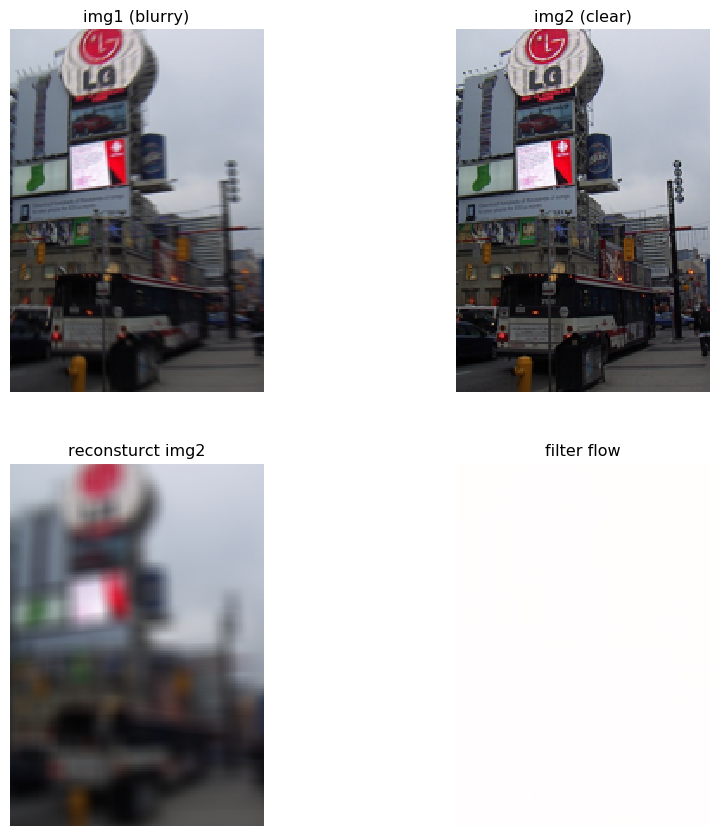

In [72]:
objDemoShowFlow = DemoShowFlow()

figWinNumHeight, figWinNumWidth = 2, 2
plt.figure(figsize=(11,11), dpi=96, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1 
plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1     
plt.imshow((blurImage.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('img1 (blurry)')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1    
plt.imshow((clearImage.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('img2 (clear)')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1       
plt.imshow((reconstructedHR.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('reconsturct img2')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
flowVisShow=torch.from_numpy(filterFlowMap)
UV = objDemoShowFlow.filterFlow2UV(flowVisShow).detach().numpy()
UV = UV/np.ceil(kernel_size/2)
#UV = UV/UV.max()
flowVisShow = objDemoShowFlow.computeColor(UV[0], UV[1])/255.    
plt.imshow(flowVisShow) # torch.from_numpy(flowVis)
plt.axis('off')
plt.title('filter flow')

#misc.imsave('deblur_filterflow.png', flowVisShow*255, format='png')

Text(0.5, 1.0, 'filter flow')

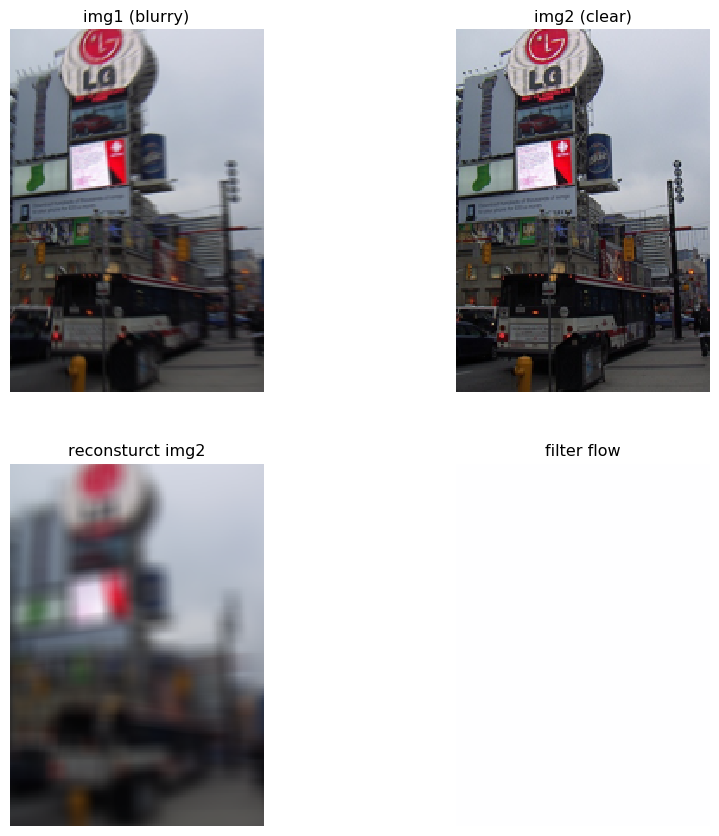

In [47]:
objDemoShowFlow = DemoShowFlow()

figWinNumHeight, figWinNumWidth = 2, 2
plt.figure(figsize=(11,11), dpi=96, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1 
plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1     
plt.imshow((blurImage.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('img1 (blurry)')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1    
plt.imshow((clearImage.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('img2 (clear)')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1       
plt.imshow((reconstructedHR.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('reconsturct img2')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
flowVisShow=torch.from_numpy(filterFlowMap)
UV = objDemoShowFlow.filterFlow2UV(flowVisShow).detach().numpy()
UV = UV/np.ceil(kernel_size/2)
#UV = UV/UV.max()
flowVisShow = objDemoShowFlow.computeColor(UV[0], UV[1])/255.    
plt.imshow(flowVisShow) # torch.from_numpy(flowVis)
plt.axis('off')
plt.title('filter flow')

#misc.imsave('deblur_filterflow.png', flowVisShow*255, format='png')

Text(0.5, 1.0, 'filter flow')

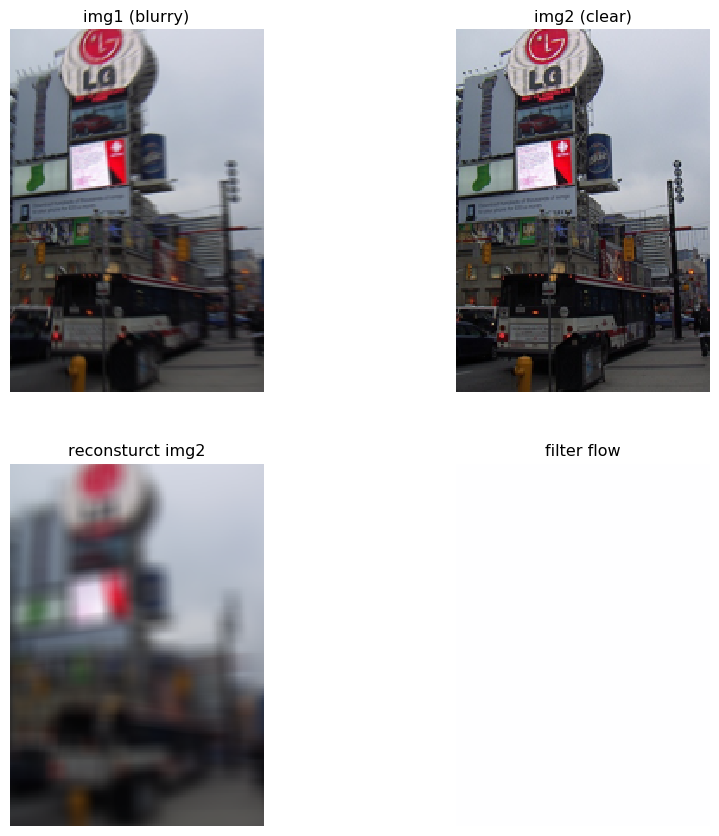

In [48]:
objDemoShowFlow = DemoShowFlow()

figWinNumHeight, figWinNumWidth = 2, 2
plt.figure(figsize=(11,11), dpi=96, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1 
plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1     
plt.imshow((blurImage.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('img1 (blurry)')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1    
plt.imshow((clearImage.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('img2 (clear)')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1       
plt.imshow((reconstructedHR.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('reconsturct img2')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
flowVisShow=torch.from_numpy(filterFlowMap)
UV = objDemoShowFlow.filterFlow2UV(flowVisShow).detach().numpy()
UV = UV/np.ceil(kernel_size/2)
#UV = UV/UV.max()
flowVisShow = objDemoShowFlow.computeColor(UV[0], UV[1])/255.    
plt.imshow(flowVisShow) # torch.from_numpy(flowVis)
plt.axis('off')
plt.title('filter flow')

#misc.imsave('deblur_filterflow.png', flowVisShow*255, format='png')

Text(0.5, 1.0, 'filter flow')

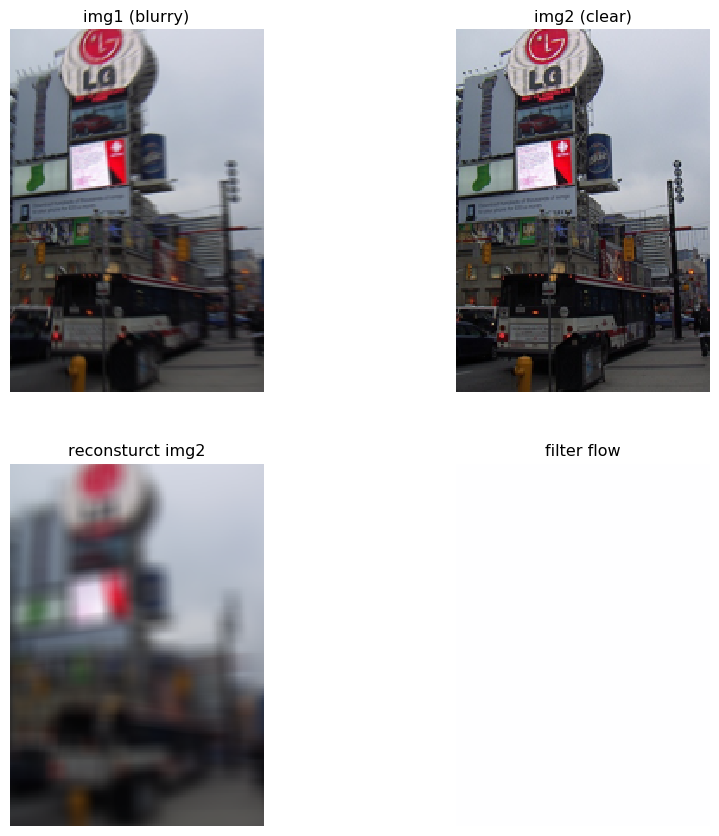

In [49]:
objDemoShowFlow = DemoShowFlow()

figWinNumHeight, figWinNumWidth = 2, 2
plt.figure(figsize=(11,11), dpi=96, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1 
plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1     
plt.imshow((blurImage.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('img1 (blurry)')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1    
plt.imshow((clearImage.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('img2 (clear)')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1       
plt.imshow((reconstructedHR.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('reconsturct img2')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
flowVisShow=torch.from_numpy(filterFlowMap)
UV = objDemoShowFlow.filterFlow2UV(flowVisShow).detach().numpy()
UV = UV/np.ceil(kernel_size/2)
#UV = UV/UV.max()
flowVisShow = objDemoShowFlow.computeColor(UV[0], UV[1])/255.    
plt.imshow(flowVisShow) # torch.from_numpy(flowVis)
plt.axis('off')
plt.title('filter flow')

#misc.imsave('deblur_filterflow.png', flowVisShow*255, format='png')

Text(0.5, 1.0, 'filter flow')

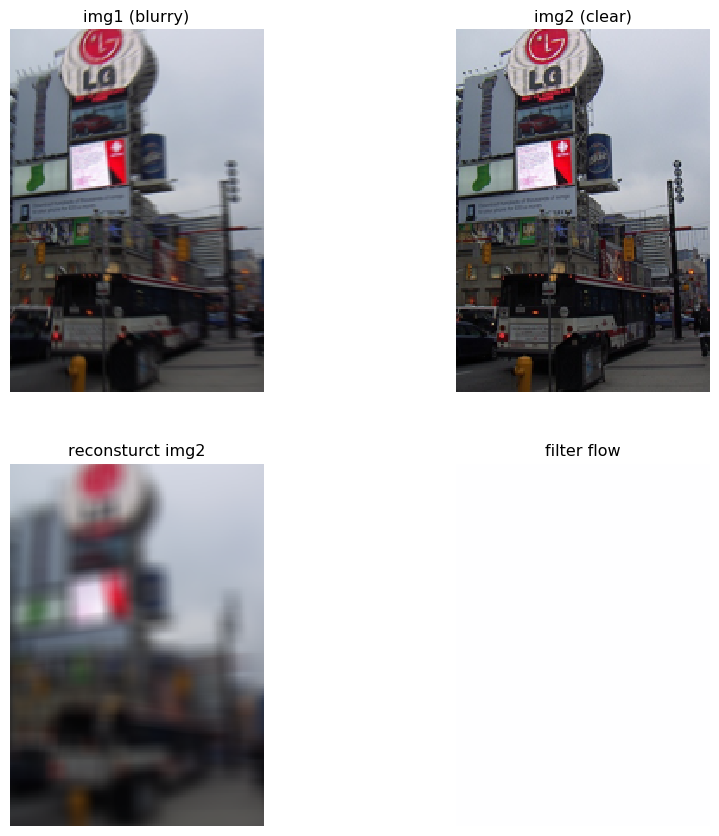

In [50]:
objDemoShowFlow = DemoShowFlow()

figWinNumHeight, figWinNumWidth = 2, 2
plt.figure(figsize=(11,11), dpi=96, facecolor='w', edgecolor='k') # figsize -- inch-by-inch
plt.clf()
subwinCount = 1 
plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1     
plt.imshow((blurImage.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('img1 (blurry)')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1    
plt.imshow((clearImage.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('img2 (clear)')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1       
plt.imshow((reconstructedHR.clip(-1,1)+1)/2)
plt.axis('off')
plt.title('reconsturct img2')


plt.subplot(figWinNumHeight,figWinNumWidth,subwinCount)
subwinCount += 1
flowVisShow=torch.from_numpy(filterFlowMap)
UV = objDemoShowFlow.filterFlow2UV(flowVisShow).detach().numpy()
UV = UV/np.ceil(kernel_size/2)
#UV = UV/UV.max()
flowVisShow = objDemoShowFlow.computeColor(UV[0], UV[1])/255.    
plt.imshow(flowVisShow) # torch.from_numpy(flowVis)
plt.axis('off')
plt.title('filter flow')

#misc.imsave('deblur_filterflow.png', flowVisShow*255, format='png')